# X-AI with SHAP for SCC Polytech Performance Regression

In [3]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns

### Load dataset

In [4]:
# load dataset
dataset = pd.read_csv("dataset/scc_data.csv")

In [6]:
data = dataset
data.head()

,Id,UID,GID,Area,JobName,Partition,ReqNodes,ReqCPUS,Timelimit,Submit,Start,Elapsed,Priority,State,ExitCode
0,0,1420,88068,astrophys,Smilei0,tornado,70,1960,10-00:00:00,2021-08-11T16:53:04,2021-09-17T09:46:21,1-11:27:29,1,CANCELLED by 50260,0:0
1,1,52951,3414,phys,v149_td,tornado,2,56,14-00:00:00,2021-08-18T10:38:10,2021-08-18T10:46:12,14-00:00:38,1,TIMEOUT,0:0
2,2,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:50:05,2021-08-18T14:50:05,13-21:05:40,1,CANCELLED by 50341,0:0
3,3,24801,97723,mech,fluent,tornado,6,168,14-00:00:00,2021-08-18T14:52:31,2021-08-18T14:52:32,13-21:04:39,1,CANCELLED by 50341,0:0
4,4,70802,33028,energ,dcss.slurm,tornado-k40,1,1,14-00:00:00,2021-08-19T15:33:49,2021-08-19T15:33:50,14-00:00:04,1,TIMEOUT,0:0


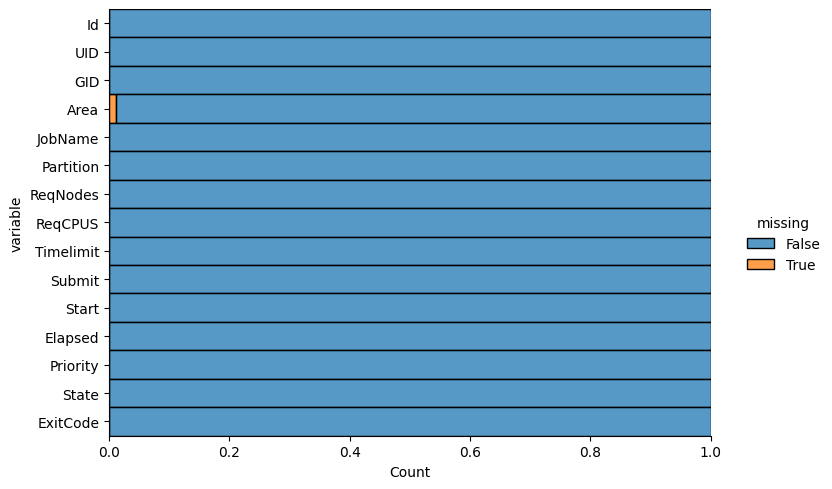

In [7]:
# check missing data
sns.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

In [8]:
# fill missing values
data.fillna("unknown", inplace = True)

In [9]:
# check number of different instances per each categorical variable
print("#Area = ", data["Area"].nunique())
print("#JobName = ", data["JobName"].nunique())
print("#Partition = ", data["Partition"].nunique())
print("#State = ", data["State"].nunique())
print("#Exit-code = ", data["ExitCode"].nunique())

#Area =  11
#JobName =  801484
#Partition =  5
#State =  196
#Exit-code =  85


### Preprocessing

In [17]:
# check information of dataset
print("Number of samples: ", len(data.index))
print("Columns = ", data.columns)
print("#Columns = ", len(data.columns))

Number of samples:  1290729
Columns =  Index(['Id', 'UID', 'GID', 'Area', 'JobName', 'Partition', 'ReqNodes',
       'ReqCPUS', 'Timelimit', 'Submit', 'Start', 'Elapsed', 'Priority',
       'State', 'ExitCode'],
      dtype='object')
#Columns =  15


Dates encoding

In [19]:
import calendar

def encoding_date(data, name_col):
    # preprocess the dates 
    dates_mod = pd.to_datetime(data[name_col])
    dict_dates = {}
    dict_dates[name_col+"_Year"] = []
    dict_dates[name_col+"_Month"] = []
    dict_dates[name_col+"_DayofWeek"] = []
    dict_dates[name_col+"_Day"] = []
    dict_dates[name_col+"_Hour"] = []
    dict_dates[name_col+"_Minute"] = []
    dict_dates[name_col+"_Second"] = []
    
    # add the preprocessed dates
    for i in range(len(data)):
        # categorical values
        dict_dates[name_col+"_Year"].append(dates_mod[i].year)
        dict_dates[name_col+"_Month"].append(dates_mod[i].month)
        dict_dates[name_col+"_DayofWeek"].append(dates_mod[i].day_of_week)
        # take normalized day respect max-days of month
        max_days_month = calendar.monthrange(dates_mod[i].year, dates_mod[i].month)[1]
        dict_dates[name_col+"_Day"].append(dates_mod[i].day/max_days_month)
        # cyclic sin values
        dict_dates[name_col+"_Hour"].append(dates_mod[i].hour)
        dict_dates[name_col+"_Minute"].append(dates_mod[i].minute)
        dict_dates[name_col+"_Second"].append(dates_mod[i].second)

    """
        By encoding hours, minutes, and seconds using the sine function, you are preserving the 
        cyclic nature of time in a continuous representation that can be understood by machine learning models.
        This can potentially help the model capture patterns related to cyclic variations in time data.
    """
    
    dict_dates = {key: pd.to_numeric(value) for key, value in dict_dates.items()}

    # add preprocessed dates to dataset columns
    data = pd.concat([data, pd.DataFrame({
            name_col+"_Year": dict_dates[name_col+"_Year"].astype(str),                 # year categorical
            name_col+"_Month": dict_dates[name_col+"_Month"].astype(str),               # month categorical
            name_col+"_DayofWeek": dict_dates[name_col+"_DayofWeek"].astype(str),       # day of week categorical
            name_col+"_Day": dict_dates[name_col+"_Day"],                               # day normalized respect max_days_month
            name_col+"_Hour": np.sin(2 * np.pi * dict_dates[name_col+"_Hour"]/24),      # hour consider cycle of 24h
            name_col+"_Minute": np.sin(2 * np.pi * dict_dates[name_col+"_Minute"]/60),  # min consider cycle of 60m
            name_col+"_Second": np.sin(2 * np.pi * dict_dates[name_col+"_Second"]/60)   # sec consider cycle of 60s
        })], axis = 1, ignore_index = False)

    return data

Transcurring time encoding  
Format: D-HH:MM:SS

In [20]:
# function to convert transcurred time to seconds
def time_conversion(time_data):
    # extract time units
    if "-" in time_data:
        days, timer = time_data.split("-")
    else:
        days = 0
        timer = time_data 
    
    days = int(days)
    hours, min, sec = map(int, timer.split(":"))

    # calculate total seconds
    total_sec = days*24*60*60 + hours*60*60 + min*60 + sec
    
    return total_sec

In [21]:
# function to encode transcurred time for entire column
def encoding_time(data, name_col):
    data[name_col+"_tsec"] = data[name_col].apply(time_conversion)

    return data

One-hot encoding for categorical variables

In [22]:
# one-hot encoder for categorical variables 
def encoding_categories(data, list_categories):
    # generate one-hot encoding variables
    tmp_data = pd.get_dummies(data[list_categories])
    tmp_data = tmp_data.astype(int)
    # concatenate with original dataset    
    data = pd.concat([data, tmp_data], axis = 1, ignore_index = False)

    return data

Final pipeline for data preprocessing

In [23]:
# master function pipeline for preprocessing input data
def preprocessing_pipeline(data):    
    # drop Id, UID, GID
    data = data.drop(columns = ["Id", "UID", "GID", "JobName"])
    # encode the Submit dates
    data = encoding_date(data, "Submit")
    # encode the Start dates
    data = encoding_date(data, "Start")
    # encode the Time limit
    data = encoding_time(data, "Timelimit")
    # encode the Time elapsed
    data = encoding_time(data, "Elapsed")
    # drop some preprocessed columns
    data = data.drop(columns = ["Submit", "Start", "Timelimit", "Elapsed"])

    # one-hot encoding for categorical variables
    list_cat_vars = ["Area", "Partition", "State", "ExitCode",
                     "Submit_Year", "Submit_Month", "Submit_DayofWeek",
                     "Start_Year", "Start_Month", "Start_DayofWeek"]
    
    data = encoding_categories(data, list_cat_vars)    
    # drop the original preprocessed columns
    data = data.drop(columns = list_cat_vars)    

    return data

In [24]:
# preprocess entire data
data = preprocessing_pipeline(data)
data.tail()

,ReqNodes,ReqCPUS,Priority,Submit_Day,Submit_Hour,Submit_Minute,Submit_Second,Start_Day,Start_Hour,Start_Minute,...,Start_Month_7,Start_Month_8,Start_Month_9,Start_DayofWeek_0,Start_DayofWeek_1,Start_DayofWeek_2,Start_DayofWeek_3,Start_DayofWeek_4,Start_DayofWeek_5,Start_DayofWeek_6
1290724,1,28,480,1.0,-0.258819,-0.951057,5.665539e-16,1.0,-0.258819,-0.951057,...,0,0,0,0,0,1,0,0,0,0
1290725,1,28,480,1.0,-0.258819,-0.951057,-9.781476e-01,1.0,-0.258819,-0.951057,...,0,0,0,0,0,1,0,0,0,0
1290726,1,28,480,1.0,-0.258819,-0.978148,8.660254e-01,1.0,-0.258819,-0.978148,...,0,0,0,0,0,1,0,0,0,0
1290727,1,1,233,1.0,-0.258819,-0.809017,8.660254e-01,1.0,-0.258819,-0.809017,...,0,0,0,0,0,1,0,0,0,0
1290728,1,1,233,1.0,-0.258819,-0.587785,9.945219e-01,1.0,-0.258819,-0.587785,...,0,0,0,0,0,1,0,0,0,0


In [25]:
# check columns metadata 
data.columns

Index(['ReqNodes', 'ReqCPUS', 'Priority', 'Submit_Day', 'Submit_Hour',
       'Submit_Minute', 'Submit_Second', 'Start_Day', 'Start_Hour',
       'Start_Minute',
       ...
       'Start_Month_7', 'Start_Month_8', 'Start_Month_9', 'Start_DayofWeek_0',
       'Start_DayofWeek_1', 'Start_DayofWeek_2', 'Start_DayofWeek_3',
       'Start_DayofWeek_4', 'Start_DayofWeek_5', 'Start_DayofWeek_6'],
      dtype='object', length=354)

In [ ]:
# split independent (X) and dependent variable (Y)
